# Juliaで精度保証付き高速フーリエ変換

データが $N$ 個の離散フーリエ変換 (DFT:discrete Fourier transform)$\newcommand{\C}{\mathbb{C}}$

$$
X_{k}=\sum_{n=0}^{N-1} x_{n} W_{N}^{k n},\quad X\in\C^N
$$

に対する高速フーリエ変換 (FFT:Fast Fourier Transform) の精度保証付き数値計算を考える。
FFTは20世紀の10大アルゴリズムの一つとも言われ、脚光を浴びるようになったのは1965年のJ.W.Cooleyと J.W.Tukey による論文（文献1）からである。なお、起源はガウスまで遡ると言われていて、巨人の大きさは果てしないようである。

JuliaではFFTのライブラリとして、`FFTW.jl`が準備されており、OCamlで最適なCのコードを自動生成する仕組みとなっている（筆者は詳しく分かっていない）。

## 離散フーリエ変換(DFT)
$\newcommand{\C}{\mathbb{C}}$
データが $N$ 個の離散フーリエ変換を $X\in\C^N$ とした場合、入力を $x\in\C^N$ として離散フーリエ変換は以下のように書くことができる。

$$
\left(\begin{array}{c}
X_{0} \\
X_{1} \\
X_{2} \\
\vdots \\
X_{N-1}
\end{array}\right)=\left(\begin{array}{ccccc}
1 & 1 & 1 & \cdots & 1 \\
1 & e^{-i \frac{2 \pi}{N}} & e^{-i \frac{4 \pi}{N}} & \cdots & e^{-i \frac{2 \pi(N-1)}{N}} \\
1 & e^{-i \frac{4 \pi}{N}} & e^{-i \frac{8 \pi}{N}} & \cdots & e^{-i \frac{4 \pi(N-1)}{N}} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & e^{-i \frac{2 \pi(N-1)}{N}} & e^{-i \frac{4 \pi(N-1)}{N}} & \cdots & e^{-i \frac{2 \pi(N-1)(N-1)}{N}}
\end{array}\right)\left(\begin{array}{c}
x_{0} \\
x_{1} \\
x_{2} \\
\vdots \\
x_{N-1}
\end{array}\right).
$$

ここで $W^n_N$ は回転因子といい、以下で定義される。

$$
W^n_N := e^{-i\frac{2 \pi}{N}n} = \cos \left(\frac{2 \pi}{N}n\right)-i \sin \left(\frac{2 \pi}{N}n\right)
$$

これを用いると、

$$
\left(\begin{array}{c}
X_{0} \\
X_{1} \\
X_{2} \\
\vdots \\
X_{N-1}
\end{array}\right)=\left(\begin{array}{ccccc}
1 & 1 & 1 & \cdots & 1 \\
1 & W_{N} & W_{N}^{2} & \cdots & W_{N}^{N-1} \\
1 & W_{N}^{2} & W_{N}^{4} & \cdots & W_{N}^{2(N-1)} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & W_{N}^{(N-1)} & W_{N}^{2(N-1)} & \cdots & W_{N}^{(N-1)(N-1)}
\end{array}\right)\left(\begin{array}{c}
x_{0} \\
x_{1} \\
x_{2} \\
\vdots \\
x_{N-1}
\end{array}\right).
$$

すなわち

$$
X_{k}=\sum_{n=0}^{N-1} x_{n} W_{N}^{k n},
$$

ただし、$0\leq k < N$である。

## 高速フーリエ変換(FFT)

FFTはDFTを高速に行うアルゴリズムである。DFTでは、 $X_0$ から $X_{N−1}$ の $N$ 回の計算を行うために、単純な計算方法では $N^2$ 回複素数の四則演算を実行して計算する。しかし、データ数 $N$ が2の冪乗である場合、FFTアルゴリズムを用いることで、複素数の四則演算を $N \log N$ に比例する回数に減らすことができる。

$$
\begin{array}{l}
\displaystyle X_{k}^{(0)}=\sum_{n=0}^{N / 2-1} W_{N / 2}^{n k} x_{2 n} \quad(0 \leq k<N / 2) \\[2mm]
\displaystyle X_{k}^{(1)}=\sum_{n=0}^{N / 2-1} W_{N / 2}^{n k} x_{2 n+1} \quad(0 \leq k<N / 2)\\[2mm]
\end{array}
$$

$$
\left\{\begin{array}{l}
\displaystyle X_{k}=X_{n}^{(0)}+W_{N}^{k} X_{n}^{(1)}, \\
\displaystyle X_{k+N / 2}=X_{n}^{(0)}-W_{N}^{k} X_{n}^{(1)} \quad(0 \leq k<N / 2).
\end{array}\right.
$$

この考え方を利用したものがCooley-Tukey FFTアルゴリズム(文献1)である。

## Cooley-Tukey FFTアルゴリズムの実装

Juliaを使ってCooley-Tukey FFTアルゴリズムに区間演算を実装する。以下のコードはJuliaApproximationの[`FastTransforms.jl`](https://github.com/JuliaApproximation/FastTransforms.jl)内のコード[`fftBigFloat.jl`](https://github.com/JuliaApproximation/FastTransforms.jl/blob/4a076c9fbacfe5201124cfe3b1d7002dbb0a8c7b/src/fftBigFloat.jl#L11)を参考に、引数に区間ベクトルを取れるように修正したものである。オリジナルは"the Numerical Recipes in C"の`c_radix2.c`である。

In [1]:
versioninfo()

Julia Version 1.10.0
Commit 3120989f39b (2023-12-25 18:01 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: macOS (arm64-apple-darwin22.4.0)
  CPU: 8 × Apple M2
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, apple-m1)
  Threads: 5 on 4 virtual cores
Environment:
  JULIA_NUM_THREADS = 4


In [2]:
using Pkg
Pkg.status("IntervalArithmetic")

Status `~/.julia/environments/v1.10/Project.toml`
  [d1acc4aa] IntervalArithmetic v0.22.5


In [19]:
#Cooley-Tukey FFTアルゴリズム
function generic_fft_pow2!(x::Vector{T}) where T
    n,big2 = length(x),2one(T)
    nn,j = n÷2,1
    for i=1:2:n-1
        if j>i
            x[j], x[i] = x[i], x[j]
            x[j+1], x[i+1] = x[i+1], x[j+1]
        end
        m = nn
        while m ≥ 2 && j > m
            j -= m
            m = m÷2
        end
        j += m
    end
    logn = 2
    while logn < n
        θ = -big2/logn
        wtemp = sinpi(θ/2)
        wpr, wpi = -2wtemp^2, sinpi(θ)
        wr, wi = one(T), zero(T)
        for m=1:2:logn-1
            for i=m:2logn:n
                j = i+logn
                mixr, mixi = wr*x[j]-wi*x[j+1], wr*x[j+1]+wi*x[j]
                x[j], x[j+1] = x[i]-mixr, x[i+1]-mixi
                x[i], x[i+1] = x[i]+mixr, x[i+1]+mixi
            end
            wr = (wtemp=wr)*wpr-wi*wpi+wr
            wi = wi*wpr+wtemp*wpi+wi
        end
        logn = logn << 1
    end
    return x
end

function interlace(a::Vector{S},b::Vector{V}) where {S,V}
    na=length(a);nb=length(b)
    T=promote_type(S,V)
    if nb≥na
        ret=zeros(T,2nb)
        ret[1:2:1+2*(na-1)]=a
        ret[2:2:end]=b
        ret
    else
        ret=zeros(T,2na-1)
        ret[1:2:end]=a
        if !isempty(b)
            ret[2:2:2+2*(nb-1)]=b
        end
        ret
    end
end

function generic_fft_pow2(x::Vector{Complex{T}}) where T
    y = interlace(real(x),imag(x))
    generic_fft_pow2!(y)
    return complex.(y[1:2:end],y[2:2:end])
end

generic_fft_pow2(x::Vector{T}) where {T} = generic_fft_pow2(complex(x))

generic_fft_pow2 (generic function with 2 methods)

追記（2024.2.7）IntervalArithmetic.jlの仕様変更によって、上のコードは区間演算のNGフラグが立ってしまう。そのため、`Vector{interval{T}}`でコードを書き換える。

In [ ]:
#Cooley-Tukey FFTアルゴリズム
function generic_fft_pow2!(x::Vector{T}) where T
    n,big2 = length(x),2one(T)
    nn,j = n÷2,1
    for i=1:2:n-1
        if j>i
            x[j], x[i] = x[i], x[j]
            x[j+1], x[i+1] = x[i+1], x[j+1]
        end
        m = nn
        while m ≥ 2 && j > m
            j -= m
            m = m÷2
        end
        j += m
    end
    logn = 2
    while logn < n
        θ = -big2/logn
        wtemp = sinpi(θ/2)
        wpr, wpi = -2wtemp^2, sinpi(θ)
        wr, wi = one(T), zero(T)
        for m=1:2:logn-1
            for i=m:2logn:n
                j = i+logn
                mixr, mixi = wr*x[j]-wi*x[j+1], wr*x[j+1]+wi*x[j]
                x[j], x[j+1] = x[i]-mixr, x[i+1]-mixi
                x[i], x[i+1] = x[i]+mixr, x[i+1]+mixi
            end
            wr = (wtemp=wr)*wpr-wi*wpi+wr
            wi = wi*wpr+wtemp*wpi+wi
        end
        logn = logn << 1
    end
    return x
end

function interlace(a::Vector{S},b::Vector{V}) where {S,V}
    na=length(a);nb=length(b)
    T=promote_type(S,V)
    if nb≥na
        ret=zeros(T,2nb)
        ret[1:2:1+2*(na-1)]=a
        ret[2:2:end]=b
        ret
    else
        ret=zeros(T,2na-1)
        ret[1:2:end]=a
        if !isempty(b)
            ret[2:2:2+2*(nb-1)]=b
        end
        ret
    end
end

function generic_fft_pow2(x::Vector{Complex{T}}) where T
    y = interlace(real(x),imag(x))
    generic_fft_pow2!(y)
    return complex.(y[1:2:end],y[2:2:end])
end

generic_fft_pow2(x::Vector{T}) where {T} = generic_fft_pow2(complex(x))

## Bluestein(Chirp z)アルゴリズム

Cooley-Tukey FFTアルゴリズムでは、データ数 $N$ が2の冪乗の場合しか計算できない。これを解決したのが[Bluestein(Chirp z)アルゴリズム](https://www.dsprelated.com/freebooks/mdft/Bluestein_s_FFT_Algorithm.html)である。任意のデータ数 $N$ のDFTを離散畳み込みを利用してFFTで計算する。

\begin{align*}
X_{k} &=\sum_{n=0}^{N-1} x_{n} W_{N}^{k n}\\
        &=\sum_{n=0}^{N-1} x_{n} W_{N}^{-\frac{(k-n)^{2}}{2}+\frac{k^{2}}{2}+\frac{n^{2}}{2}}\\
        &=W_{2 N}^{k^{2}} \sum_{n=0}^{N-1}\left\{x_n W_{2N}^{n^{2}}\right\} W_{2 N}^{-(k-n)^{2}}
\end{align*}

ここで、点列 $\alpha=\left\{\alpha_{n}\right\}$, $\beta=\left\{\beta_{n}\right\}$ を以下のように定め, $X_{k}$ を書き換える。

$$
\alpha_{n} :=x_n W_{2 N}^{n^{2}},\quad\beta_{n} :=W_{2 N}^{-n^{2}}
$$

$$
X_{k}=\overline{\beta_{k}} \sum_{n=0}^{N-1} \alpha_{n} \beta_{k-n}=\overline{\beta_{k}}\left(\alpha * \beta\right)_{k}.
$$

次に、離散畳み込み $\alpha * \beta$ を考える。いま$\alpha$, $\beta$ の長さを $n_{u}$, $n_{v}$ として、$L$ を $L \ge n_{u}+ n_{v} - 1$ を満たす最小の2の冪乗数とする。そして長さが $L$ の点列 $\alpha'=\left\{\alpha_{n}'\right\}$, $\beta'=\left\{\beta_{n}'\right\}$ を次のように定める。

$$
\alpha_{n}^{\prime}=\left\{\begin{array}{ll}
\alpha_n & (0 \leq n<N) \\
0 & (N \leq n<L)
\end{array}\right.
$$

$$
\left\{\begin{aligned}
\beta_{0}^{\prime} &=\beta_{0}\quad(n=0) \\
\beta_{n}^{\prime}=\beta_{L-n}^{\prime} &=\beta_{n} \quad (0<n<N) \\
\beta_{n}^{\prime} &=0 \quad (N \leq n \leq L-N).
\end{aligned}\right.
$$

Cooley-Tukey FFTを用いて$\alpha^{\prime}$, $\beta^{\prime}$ のDFTを計算し、ベクトルの要素毎の積をとり、そのベクトルを逆フーリエ変換 (IFFT:inverse fast Fourier transform) して出てくる値を $\gamma_{k}^{\prime}$ とすると $ \gamma_{k}^{\prime}=(\alpha * \beta)_{k} $ となる。以上より、$X_{k}$ が求まる。

$$
X_{k}=\overline{\beta_{k}} \gamma_{k}^{\prime}.
$$



In [4]:
function Bluestein_fft(x::Vector{T}) where T
    n = length(x)
    ispow2(n) && return generic_fft_pow2(x)
    ks = range(zero(real(T)),stop=n-one(real(T)),length=n)
    Wks = exp.((-im).*convert(T,π).*ks.^2 ./ n)
    xq, wq = x.*Wks, conj([exp(-im*convert(T,π)*n);reverse(Wks);Wks[2:end]])
    return Wks.*conv(xq,wq)[n+1:2n]
end

function conv(u::StridedVector{T}, v::StridedVector{T}) where T
    nu,nv = length(u),length(v)
    n = nu + nv - 1
    np2 = nextpow(2,n)
    append!(u,zeros(T,np2-nu)),append!(v,zeros(T,np2-nv))
    y = generic_ifft_pow2(generic_fft_pow2(u).*generic_fft_pow2(v))
    y = T<:Real ? real(y[1:n]) : y[1:n]
end

function generic_ifft_pow2(x::Vector{Complex{T}}) where T
    y = interlace(real(x),-imag(x))
    generic_fft_pow2!(y)
    return complex.(y[1:2:end],-y[2:2:end])/length(x)
end

generic_ifft_pow2 (generic function with 1 method)

## 計算結果

区間演算を用いたCooley-Tukey アルゴリズム、Bluesteinアルゴリズムと区間演算を用いない通常の`FFTW.jl`での計算時間を比較する。

In [10]:
# using BenchmarkTools
using IntervalArithmetic, FFTW
N  = 2^17
x  = randn(N)
# ix = map(Interval, x)
ix = interval(x)

@time generic_fft_pow2(ix)
@time generic_fft_pow2(ix)

@time fft(x)
@time fft(x);

  0.287718 seconds (14 allocations: 30.000 MiB, 2.15% gc time)
  0.270533 seconds (14 allocations: 30.000 MiB, 0.90% gc time)


  0.001487 seconds (8 allocations: 4.000 MiB)
  0.001571 seconds (8 allocations: 4.000 MiB)


Cooley-Tukey FFTのアルゴリズムを用いたFFTの区間演算でFFTWの約100倍計算時間がかかる。

In [12]:
using IntervalArithmetic
N  = 10000
x  = randn(N)
# ix = map(Interval, x)
ix = interval(x)
@time Bluestein_fft(ix)
@time Bluestein_fft(ix)
@time fft(x)
@time fft(x);

ArgumentError: ArgumentError: `isnan` is purposely not supported for intervals. See instead `isnai`

Bluesteinアルゴリズムでは約2500倍計算時間がかかってしまい、こちらは現実的でない。よって、FFTを区間演算する際はできるならばベクトルの長さを2の冪数に限定するのが現実的である（それでも100倍計算時間がかかるけれども）。

In [6]:
using LinearAlgebra
N  = 2^13
b  = randn(N)
ib = map(Interval, b)
@time a1 = fft(b)
@time a2 = generic_fft_pow2(ib);
log2(sum(a1 .∈ a2))

  0.000512 seconds (30 allocations: 257.875 KiB)
  0.037029 seconds (700 allocations: 1.278 MiB)


13.0

一応、FFTWで計算した結果は精度保証された区間内に入っている。

## INTLABのverifyfft.mのJuliaへの実装

MATLAB上での区間演算パッケージINTLABでは、Danielson-Lanczosアルゴリズムと呼ばれているFFTの実装の区間演算版が実装されている。以下のコードはS.M.RumpによるINTLAB内の実装をJuliaに翻訳したものである。

In [5]:
using IntervalArithmetic
function verifyfft(z::Vector{Complex{Interval{T}}}, sign=1) where T
    n = length(z); col = 1; array1 = true
    if n==1
        return z
    else
        isrow_ = false
    end
    log2n = Int(round(log2(n))) #check dimension
    if 2^log2n ≠ n # return error if n is not the powers of 2
        error("length must be power of 2")
    end
    #bit-reversal
    f = 2^(log2n-1)
    v = [0;f]
    for k = 1:log2n-1
        f = f >> 1
        v = append!(v,f.+v)
    end
    z2 = zeros(Complex{Interval{T}},n,col)
    # if isa(real(z[1]),Interval)
    #     z2 = map(Interval{T},z2)
    # end
    # replace z
    for j = 1: n
        z2[j,:] = z[v[j]+1,:]
    end
    #Danielson-Lanczos algorithm
    # Z = complex.(interval(z2))
    Z = z2
    Index = reshape([1:n*col;],n,col)

    theta = sign * (0:n-1)/n; # division exact because n is power of 2
    itheta = interval(theta)
    Phi = complex.(cospi.(itheta),sinpi.(itheta)) # SLOW?
    # Phi = cospi.(theta) + im*sinpi.(theta)

    v = [1:2:n;]
    w = [2:2:n;]
    t = Z[w,:]
    Z[w,:]  = Z[v,:] - t
    Z[v,:]  = Z[v,:] + t
    for index in 1: (log2n-1)
        m = 2^index
        m2 = 2*m
        vw = reshape([1:n;],m2,Int(n/m2))
        v = vw[1: m, :]
        w = vw[m+1: m2, : ]
        indexv = reshape(Index[v[:],:],m,Int(col*n/m2))
        indexw = reshape(Index[w[:],:],m,Int(col*n/m2))
        Phi1 = repeat(Phi[1:Int(n/m):end],outer=[1,Int(col*n/m2)])
        t = Phi1 .*  Z[indexw]
        Z[indexw] = Z[indexv] - t
        Z[indexv] = Z[indexv] + t
    end
    reverse(Z[2:end,:],dims=2)
     if sign==-1
        Z = Z/interval(n)
    end
    if isrow_
        Z = transpose(Z) #transpose of Z
    end
    if array1
        Z = Z[:,1]
    end
    return Z
end

verifyfft(z::Vector{Interval{T}}, sign=1) where {T} = verifyfft(complex.(z), sign)

verifyfft (generic function with 4 methods)

In [15]:
# z = map(Interval,ones(8))
z = interval(ones(8))
a = verifyfft((z),1)
# a = verifyfft(verifyfft(z,-1))

8-element Vector{Complex{Interval{Float64}}}:
 [8.0, 8.0]_com + ([0.0, 0.0]_com)im
 [0.0, 0.0]_com + ([0.0, 0.0]_com)im
 [0.0, 0.0]_com + ([0.0, 0.0]_com)im
 [0.0, 0.0]_com + ([0.0, 0.0]_com)im
 [0.0, 0.0]_com + ([0.0, 0.0]_com)im
 [0.0, 0.0]_com + ([0.0, 0.0]_com)im
 [0.0, 0.0]_com + ([0.0, 0.0]_com)im
 [0.0, 0.0]_com + ([0.0, 0.0]_com)im

In [16]:
verifyfft(a,-1)

8-element Vector{Complex{Interval{Float64}}}:
 [1.0, 1.0]_com + ([0.0, 0.0]_com)im
 [1.0, 1.0]_com + ([0.0, 0.0]_com)im
 [1.0, 1.0]_com + ([0.0, 0.0]_com)im
 [1.0, 1.0]_com + ([0.0, 0.0]_com)im
 [1.0, 1.0]_com + ([0.0, 0.0]_com)im
 [1.0, 1.0]_com + ([0.0, 0.0]_com)im
 [1.0, 1.0]_com + ([0.0, 0.0]_com)im
 [1.0, 1.0]_com + ([0.0, 0.0]_com)im

In [10]:
# # 複素区間の半径を計算する
# import IntervalArithmetic: radius

# function radius(v::Complex{Interval{T}}) where T# mag function for complex interval vectors
#     return sqrt(interval(radius(real(v)))^2 + interval(radius(imag(v)))^2)
# end


radius (generic function with 5 methods)

## 計算結果

`verifyfft`の計算結果とCooley-Tukey FFTアルゴリズムの計算時間を比較する。

In [20]:
using IntervalArithmetic, FFTW
N  = 2^17
x  = randn(N)
# ix = map(Interval, x)
ix = interval(x)

# @time verifyfft(x)
# @time verifyfft(x)
@time verifyfft(ix)
@time z1 = verifyfft(ix)

@time generic_fft_pow2(ix)
@time z2 = generic_fft_pow2(ix)
    
sup(maximum(radius,z1)),sup(maximum(radius,z2))

  0.379715 seconds (131.88 k allocations: 478.852 MiB, 9.16% gc time)
  0.349805 seconds (131.88 k allocations: 478.852 MiB, 2.99% gc time)


  0.545030 seconds (914.28 k allocations: 90.230 MiB, 1.30% gc time, 50.58% compilation time)
  0.269188 seconds (14 allocations: 30.000 MiB)


(1.8542323232395574e-10, 3.364664280525176e-8)

こちらは上のCooley-Tukey FFTよりも若干計算速度が劣るが同程度。しかし区間演算による誤差拡大が2桁程度抑えられている。すなわちINTLABにおける実装の方が、高精度な区間演算結果を返すことができる。以下に入力のベクトルのサイズを変えた時の最大区間幅をプロットした図を示す。

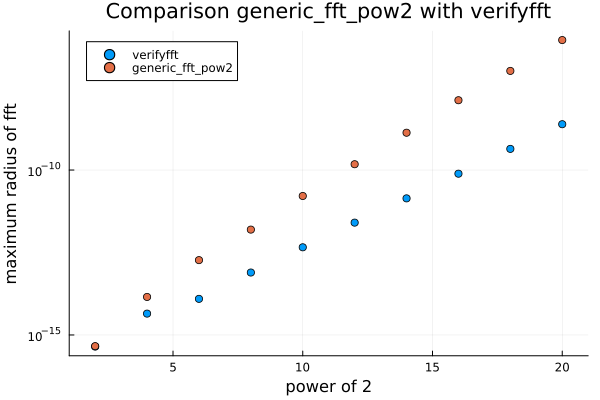

In [22]:
using Plots
index = 2:2:20
max_rad1 = zeros(size(index))
max_rad2 = zeros(size(index))
i = 1
for n ∈ index
    # a = map(Interval, randn(2^n))
    a = interval(randn(2^n))

    z1 = verifyfft(a)
    z2 = generic_fft_pow2(a)

    max_rad1[i] = sup(maximum(radius,z1))
    max_rad2[i] = sup(maximum(radius,z2))

    i += 1
end
max_rad1
plot(index, max_rad1, yscale=:log10,
    xlabel       = "power of 2",                #X軸のラベル
    ylabel       = "maximum radius of fft",   #Y軸のラベル
    xlims        =(1,21),             #X軸の範囲
    title="Comparison generic_fft_pow2 with verifyfft",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに
    size         =(600,400),          #プロットのサイズ
    label = "verifyfft",#凡例のラベル
    legend = false,                   #凡例は今回は消す   
)

plot!(index, max_rad2, yscale=:log10,
#     xlabel       ="2^n",                #X軸のラベル
#     ylabel       ="maximum radius of fft",   #Y軸のラベル
#     xlims        =(1,21),             #X軸の範囲
#     title="Comparison generic_fft_pow2 with verifyfft",       #タイトル
    linewidth    =2,                  #線幅
    seriestype = :scatter,            #点プロットに　
#     size         =(400,300),          #プロットのサイズ
    label = "generic_fft_pow2",#凡例のラベル
    legend = :topleft,                   #凡例は今回は消す
)

今回実装を行ったものは全て1次元のFFTである。2次元のFFTの計算を行う場合は
```
permutedims(verifyfft(permutedims(verifyfft(A),[2,1])),[2,1])
```
と計算を行えば良い。

In [32]:
using IntervalArithmetic

function verifyfft(z::Matrix{T}, sign=1) where T
    n, col = size(z); array1 = false
    if n==1
        if col==1
            # Z = map(T,z)
            return z
        else
            isrow_ = true
            z = z[:]
            n = col
            col = 1
        end
    else
        isrow_ = false
    end
    log2n = Int(round(log2(n))) #check dimension
    if 2^log2n ≠ n #2の倍数でない場合はエラー表示
        error("length must be power of 2")
    end
    #bit-reversal(ビットリバース)
    f = 2^(log2n-1)
    v = [0;f]
    for k = 1:log2n-1
#         f = 0.5*f
        f = f >> 1
        v = append!(v,f.+v)
    end
    z2 = zeros(T,n,col)
    # if isa(real(z[1]),Interval)
    #     z2 = map(T,z2)
    # end
    #zを入れ替え
    for j = 1: n
        z2[j,:] = z[v[j]+1,:]
    end
    #Danielson-Lanczos algorithm
    Z = z2
    # Z = complex.(interval(z2))
    Index = reshape([1:n*col;],n,col)
    
    theta = sign * (0:n-1)/n; # division exact because n is power of 2
    itheta = interval(theta)
    Phi = complex.(cospi.(itheta),sinpi.(itheta)) # SLOW?
    # Phi = cospi.(theta) + im*sinpi.(theta)

    v = [1:2:n;]
    w = [2:2:n;]
    t = Z[w,:]
    Z[w,:]  = Z[v,:] - t
    Z[v,:]  = Z[v,:] + t
    for index in 1: (log2n-1)    
        m = 2^index
        m2 = 2*m
        vw = reshape([1:n;],m2,Int(n/m2))
        v = vw[1: m, :]
        w = vw[m+1: m2, : ]
        indexv = reshape(Index[v[:],:],m,Int(col*n/m2))
        indexw = reshape(Index[w[:],:],m,Int(col*n/m2))
        Phi1 = repeat(Phi[1:Int(n/m):end],outer=[1,Int(col*n/m2)])
        t = Phi1 .*  Z[indexw]
        Z[indexw] = Z[indexv] - t 
        Z[indexv] = Z[indexv] + t
    end
    reverse(Z[2:end,:],dims=2)
     if sign==-1
        Z = Z/interval(n
            )    end
    if isrow_
        Z = transpose(Z) #転置
    end
    if array1
        Z = Z[:,1]
    end
    return Z
end
function verifyfft2(iA)
    return permutedims(verifyfft(permutedims(verifyfft(iA),[2,1])),[2,1])
end
verifyfft2(interval(ones(8,8)))

8×8 Matrix{Interval{Float64}}:
 [64.0, 64.0]_com  [0.0, 0.0]_com  …  [0.0, 0.0]_com  [0.0, 0.0]_com
  [0.0, 0.0]_com   [0.0, 0.0]_com     [0.0, 0.0]_com  [0.0, 0.0]_com
  [0.0, 0.0]_com   [0.0, 0.0]_com     [0.0, 0.0]_com  [0.0, 0.0]_com
  [0.0, 0.0]_com   [0.0, 0.0]_com     [0.0, 0.0]_com  [0.0, 0.0]_com
  [0.0, 0.0]_com   [0.0, 0.0]_com     [0.0, 0.0]_com  [0.0, 0.0]_com
  [0.0, 0.0]_com   [0.0, 0.0]_com  …  [0.0, 0.0]_com  [0.0, 0.0]_com
  [0.0, 0.0]_com   [0.0, 0.0]_com     [0.0, 0.0]_com  [0.0, 0.0]_com
  [0.0, 0.0]_com   [0.0, 0.0]_com     [0.0, 0.0]_com  [0.0, 0.0]_com

In [30]:
fft(ones(8,8))

8×8 Matrix{ComplexF64}:
 64.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
  0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im

### さらに早く計算するには
- 並列処理の設定を行う。export JULIA_NUM_THREADS=8などと、スレッド数を指定する必要あり
- planfftを利用し、inplace(計算機科学においてデータ構造の変換を行うにあたって、追加の記憶領域をほとんど使わずに行うアルゴリズム)を行う？

## まとめ

入力のベクトルに対して離散フーリエ変換を精度保証付き数値計算する方法を紹介した。現状、

- Cooley-Tukey FFTアルゴリズム、Bluesteinアルゴリズム、`verifyfft`のうち`verifyfft`の実装が速度、計算精度ともに妥当である
- それでもFFTWを使った数値計算よりも約100倍遅い（けど$N\log N$のオーダーは素晴らしい）
- FFTは離散畳み込みの精度保証に使える

本資料は以下のような文献・Web ページ等を参考にこの文章は書いています.

### 参考文献
1. James W. Cooley and John W. Tukey, An algorithm for the machine calculation of complex Fourier series, Mathematics of Computation, 19 (1965), 297-301.
1. L. R. Rabiner, R. W. Schafer, and C. M. Rader, The chirp z-transform algorithm and its application, Bell System Technical Journal, vol. 48, pp. 1249-1292, 1969, also published in IEEE Tr. Audio & Electroacoustics, vol. 17, no. 2, pp. 86-92, 1969.

<div align="right">井藤佳奈子, <a href="http://www.risk.tsukuba.ac.jp/~takitoshi/">高安亮紀</a>，2021年3月2日（最終更新：2023年5月21日）</div>